## Árboles de decisión

Los árboles de decisión son modelos ampliamente utilizados para tareas de clasificación y regresión. Esencialmente, ellos aprenden una jerarquía de preguntas `if/else`, lo que lleva a una decisión.

Estas preguntas son similares a las preguntas que podría formular en un juego de 20 preguntas.

Imagine que desea distinguir entre los siguientes cuatro animales: osos, halcones, pingüinos y delfines. Su objetivo es llegar a la respuesta correcta haciendo tan pocas preguntas if/else como sea posible. Puede comenzar preguntando si el animal tiene plumas, una pregunta que reduce sus posibles animales a solo dos. Si la respuesta es "sí", puede hacer otra pregunta que podría ayudarlo a distinguir entre halcones y pingüinos. Por ejemplo, podrías preguntar si el animal puede volar. Si el animal no tiene plumas, sus posibles opciones de animales son los delfines y los osos, y tendrá que hacer una pregunta para distinguir entre estos dos animales, por ejemplo, preguntando si el animal tiene aletas.

Esta serie de preguntas puede ser respondida, utilizando un árbol de decisión.

In [1]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt


def dibuja_arbol1(ax=None):
    import graphviz
    if ax is None:
        ax = plt.gca()
    grafo_ejemplo= graphviz.Digraph(node_attr={'shape': 'box'},
                               edge_attr={'labeldistance': "10.5"},
                               format="png")
    grafo_ejemplo.node("0", "Tiene plumas?")
    grafo_ejemplo.node("1", "Puede volar?")
    grafo_ejemplo.node("2", "Tiene aletas?")
    grafo_ejemplo.node("3", "Halcon")
    grafo_ejemplo.node("4", "Pinguino")
    grafo_ejemplo.node("5", "Delfin")
    grafo_ejemplo.node("6", "Oso")
    grafo_ejemplo.edge("0", "1", label="True")
    grafo_ejemplo.edge("0", "2", label="False")
    grafo_ejemplo.edge("1", "3", label="True")
    grafo_ejemplo.edge("1", "4", label="False")
    grafo_ejemplo.edge("2", "5", label="True")
    grafo_ejemplo.edge("2", "6", label="False")
    grafo_ejemplo.render("arbol_decision")
    ax.imshow(imageio.imread("arbol_decision.png"))
    ax.set_axis_off()

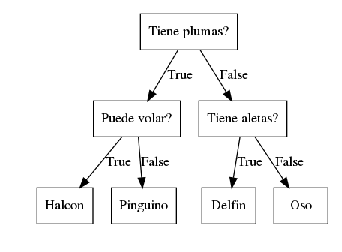

In [2]:
dibuja_arbol1()

En esta ilustración, cada nodo en el árbol representa una pregunta o un nodo terminal (también llamado hoja) que contiene la respuesta. Las aristas  conectan las respuestas a una pregunta con la siguiente pregunta que harías.

En el lenguaje del machine learning, creamos un modelo para distinguir entre cuatro clases de animales (halcones, pingüinos, delfines y osos) usando las tres características "tiene plumas", "puede volar" y "tiene aletas". En lugar de construir estos modelos a mano, podemos aprenderlos a partir de datos usando aprendizaje supervisado.

In [3]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from scipy import ndimage
from sklearn.datasets import make_moons
import re

Dibujamos un gráfico de dispersión.

In [4]:
import matplotlib as mpl
from matplotlib.colors import  colorConverter, ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Realizamos el gráfico de un árbol de decisión, utilizando el paquete `graphviz`. Aprender de  un árbol de decisiones significa aprender la secuencia de preguntas `if/else` que nos lleva a la verdadera respuesta más rápidamente. En la configuración del machine learning, estas preguntas se denominan `pruebas` (que no deben confundirse con el conjunto de pruebas, que son los datos que usamos para evaluar el grado de generalización de nuestro modelo).

Por lo general, los datos no vienen en forma de características binarias `si/no` como en el ejemplo anterior, sino que se representan como características continuas, como en el conjunto de datos de dos dimensiones. Las pruebas que se usan en datos continuos tienen la forma `¿La  característica i  es más grande que el valor a?`.


In [5]:
def imagen_arbol(arbol, buscar=None):
    try:
        import graphviz
    except ImportError:
        x = np.ones((10, 10))
        x[0, 0] = 0
        return x
    dato_punto = StringIO()
    export_graphviz(arbol, out_file=dato_punto, max_depth=3, impurity=False)
    dato = dato_punto.getvalue()
    dato = re.sub(r"muestras = [0-9]+\\n", "", dato)
    dato = re.sub(r"\\nmuestras = [0-9]+", "", dato)
    dato = re.sub(r"valor", "conteo", dato)

    grafo= graphviz.Source(dato, format="png")
    if buscar is None:
        buscar = "arbol"
    grafo.render(buscar)
    return imageio.imread(buscar + ".png")

In [12]:
def dibuja_arbol_particion(X, y, arbol, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = arbol.predict(X_grid)
    Z = Z.reshape(X1.shape)
    caras = arbol.apply(X_grid)
    caras = caras.reshape(X1.shape)
    bordes = ndimage.laplace(caras) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[bordes], X2[bordes], marker='.', s=1)

    dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [13]:
def dibuja_arbol(X, y, profundidad=1, ax=None):
    arbol = DecisionTreeClassifier(max_depth=profundidad, random_state=0).fit(X, y)
    ax = dibuja_arbol_particion(X, y, arbol, ax=ax)
    ax.set_title("Profundidad = %d" %profundidad) 
    return arbol

### Construyendo árboles de decisión

Repasemos el proceso de construcción de un árbol de decisión para  el conjunto de datos que consiste en dos formas de media luna, cada clase consta de 75 puntos de datos. Nos referiremos a este conjunto de datos como `two_moons`.

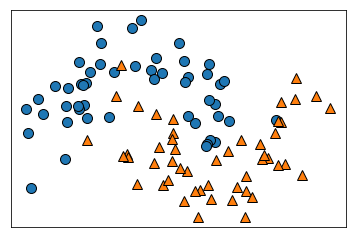

In [14]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
plt.figure()
ax = plt.gca()
dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
ax.set_xticks(())
ax.set_yticks(())
plt.show()

Para construir un árbol, el algoritmo busca en todas las pruebas posibles y encuentra el que es más informativo sobre la variable objetivo.

In [15]:
def dibuja_arbol_progresivo():
    axes = []
    for i in range(3):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                               subplot_kw={'xticks': (), 'yticks': ()})
        axes.append(ax)
    axes = np.array(axes)
    
    for i, profundidad in enumerate([1, 2, 9]):
        arbol = dibuja_arbol(X, y, profundidad=profundidad, ax=axes[i, 0])
        axes[i, 1].imshow(imagen_arbol(arbol))
        axes[i, 1].set_axis_off()

La figura siguiente  muestra en su primera parte la primera prueba que se selecciona. 

Dividir el conjunto de datos verticalmente en `x[1] = 0.0596` produce la mayor cantidad de información; es mejor separar los puntos en la clase 1 de los puntos en la clase 2. El nodo superior, también llamado raíz, representa el conjunto de datos completo, que consta de 75 puntos pertenecientes a la clase 0 y 75 puntos pertenecientes a la clase 1.

La división se hace por probando si `x[1]<= 0.0596`, indicado por una línea azúl. Si la prueba es verdadera, se asigna un punto al nodo izquierdo, que contiene 2 puntos pertenecientes a la clase 0 y 32 puntos pertenecientes a la clase 1. De lo contrario, el punto se asigna al nodo derecho, que contiene 48 puntos pertenecientes a la clase 0 y 18 puntos pertenecientes a la clase 1. Estos dos nodos corresponden a las regiones superior e inferior que se muestran en la primera parte de la siguiente figura.

Aunque la primera división (profundidad 1)  hizo un buen trabajo al separar las dos clases, la región inferior aún contiene puntos pertenecientes a la clase 0, y la región superior aún contiene puntos pertenecientes a la clase 1. 

Podemos construir un modelo más preciso repitiendo el proceso de buscando la mejor prueba en ambas regiones. El gráfico anterior(profundidad =2)  muestra que la siguiente división más informativa para la región izquierda y derecha se basa en `x[0]`.

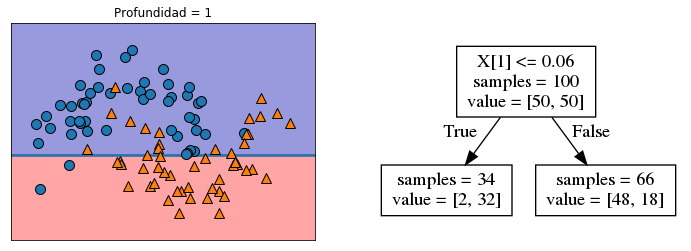

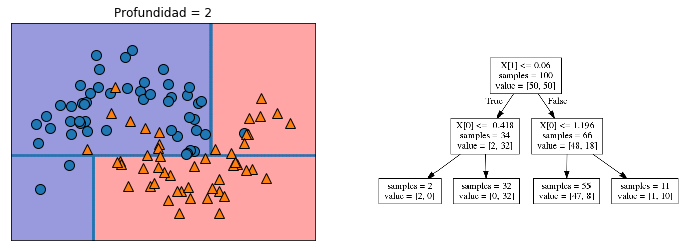

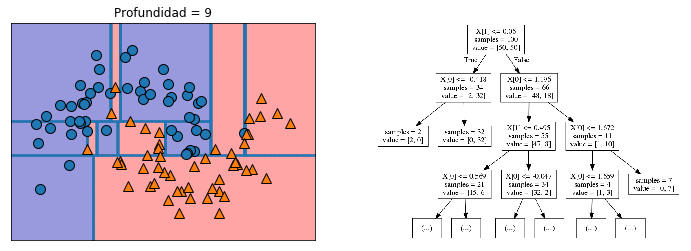

In [16]:
dibuja_arbol_progresivo()

Este proceso recursivo produce un árbol binario de decisiones, con cada nodo conteniendo una prueba. Alternativamente, se puede pensar que cada prueba divide la parte de los datos que se está considerando actualmente a lo largo de un eje. Esto produce una vista del algoritmo como la construcción de una partición jerárquica. Como cada prueba se refiere a una sola característica, las regiones en la partición resultante siempre tienen límites de eje paralelo.



Del gráfico anterior, la partición recursiva de los datos se repite hasta que cada región en la partición (cada hoja en el árbol de decisión) solo contenga un único valor objetivo (una sola clase o un único valor de regresión). Una hoja del árbol que contiene puntos de datos que comparten el mismo valor objetivo se llama `pure`. La final partición para este conjunto de datos se muestra en la parte inferior de la figura.

Se realiza una predicción en un nuevo punto de datos comprobando en qué región de la partición del espacio de características se encuentra el punto, y luego prediciendo el objetivo mayoritario (o el único objetivo en el caso de hojas puras) en esa región. La región se puede encontrar atravesando el árbol desde la raíz y  yendo a la izquierda o derecha, dependiendo de si la prueba se cumple o no.

También es posible usar árboles para tareas de regresión, usando exactamente la misma técnica. Para hacer una predicción, recorremos el árbol en función de las pruebas en cada nodo y buscamos la hoja en la que cae el nuevo punto de datos. El resultado para este punto de datos es el objetivo medio de los puntos de entrenamiento en esta hoja.

### Controlando la complejidad de los árboles aleatorios

Por lo general, construir un árbol como se describe aquí y continuar hasta que todas las hojas sean puras conduce a modelos que son muy complejos y están muy sobreajustados para los datos de entrenamiento.

La presencia de hojas puras significa que un árbol es 100% preciso en el conjunto de entrenamiento; cada punto de datos en el conjunto de entrenamiento está en una hoja que tiene la clase de mayoría correcta.

La presencia de sobrefijado, se puede ver a la izquierda del gráfico anterior. Se puede ver las regiones determinadas a pertenecer a la clase 1 en el medio de todos los puntos que pertenecen a la clase 0. Por otro lado, hay una pequeña tira predicha como clase 0 alrededor del punto perteneciente a la clase 0 a la derecha.

Esta no es la forma en que uno se imaginaría la frontera  de decisión a observar y la frontera de decisión se enfoca mucho en puntos atípicos únicos que están muy lejos de los otros puntos en esa clase.





### Estrategias

Existen dos estrategias comunes para evitar el sobreajuste: detener la creación del
árbol tempranamente (también llamado pre-poda), o construir el árbol pero luego eliminar o colapsar los nodos que contienen poca información (también llamado post-poda o simplemente poda).

Los posibles criterios para la prepoda incluyen limitar la profundidad máxima del árbol, limitar el número máximo de hojas o requerir un número mínimo de puntos en un nodo para seguir dividiéndolo. Scikit-learn implementa una pre-poda y post-poda.



In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split( 
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
arbol_decision = DecisionTreeClassifier(random_state=0)
arbol_decision.fit(X_entrenamiento, y_entrenamiento)
print("Precision en el conjunto de entrenamiento: {:.3f}".format(arbol_decision.score(X_entrenamiento, y_entrenamiento)))
print("Precision en el conjunto de pruebas: {:.3f}".format(arbol_decision.score(X_prueba, y_prueba)))

Precision en el conjunto de entrenamiento: 1.000
Precision en el conjunto de pruebas: 0.937


Si no restringimos la profundidad de un árbol de decisión, el árbol puede volverse arbitrariamente profundo y complejo. 

Los árboles sin podar son por lo tanto propensos a sobreajuste y no se generalizan bien a los datos nuevos.  Apliquemos una poda previa  al árbol, lo que detendrá el desarrollo del árbol antes de que encajemos perfectamente con los datos de entrenamiento.

Una opción es dejar de construir el árbol después de alcanzar cierta profundidad. Aquí establecemos `max_depth = 4`, lo que significa que solo se pueden hacer cuatro preguntas consecutivas. Limitar la profundidad del árbol disminuye el sobreajuste. Esto conduce a una menor precisión en el conjunto de entrenamiento, pero una mejora en el conjunto de prueba:

In [18]:
arbol_decision = DecisionTreeClassifier(max_depth=4, random_state=0)
arbol_decision.fit(X_entrenamiento, y_entrenamiento)

print("Precision en el conjunto de entrenamiento: {:.3f}".format(arbol_decision.score(X_entrenamiento, y_entrenamiento)))
print("Precision en el conjunto de pruebas: {:.3f}".format(arbol_decision.score(X_prueba, y_prueba)))

Precision en el conjunto de entrenamiento: 0.988
Precision en el conjunto de pruebas: 0.951


Podemos visualizar, los árboles usando la función `export_graphviz` desde el modulo `tree`. Este escribe un archivo en el formato `.dot`, que es un formato de archivo de texto para almacenar gráficos. Establecemos una opción para colorear los nodos para reflejar la clase mayoritaria en cada nodo y pasar la clase y los nombres de las características para que el árbol pueda etiquetarse correctamente:

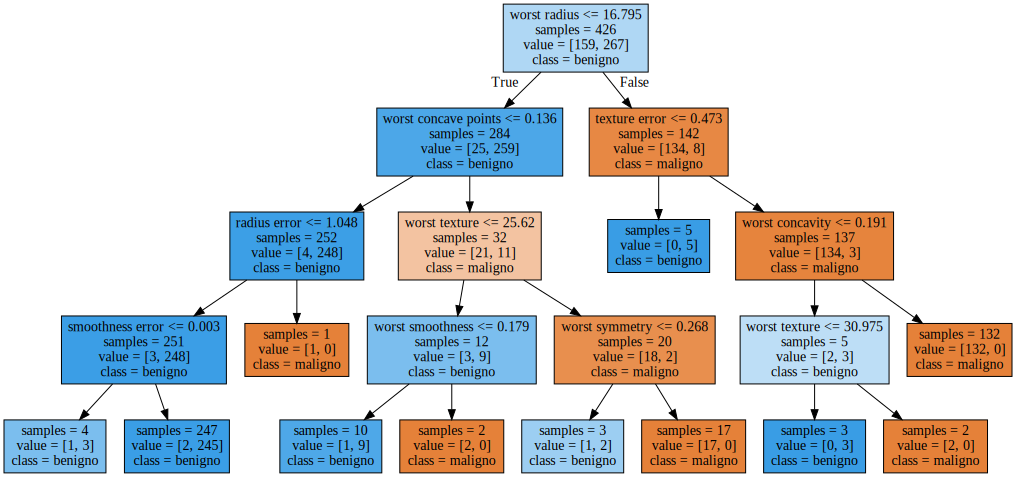

In [19]:
from sklearn.tree import export_graphviz
export_graphviz(arbol_decision, out_file="arbol_decision.dot", class_names=["maligno", "benigno"],
                feature_names=cancer.feature_names, impurity=False, filled=True)

import graphviz
with open("arbol_decision.dot") as f:
    grafo_punto = f.read()
graphviz.Source(grafo_punto)

Un método para inspeccionar el árbol que puede ser útil es descubrir qué camino toman en realidad la mayoría de los datos. `n_samples` que se muestran en cada nodo en la anterior dan la cantidad de muestras en ese nodo, mientras que `value` proporciona el número de muestras por clase. Siguiendo las ramas a la derecha, vemos que el `worst_radius <= 16.795` crea un nodo que contiene solo 8 muestras benignas pero 134 malignas.

El resto de este lado del árbol utiliza algunas distinciones más finas para dividir estas 8 muestras benignas restantes. De las 142 muestras que fueron a la derecha en la división inicial, casi todas (132) terminan en la hoja a la derecha.

Girando a la izquierda en la raíz, para `worst_radio> 16.795` terminamos con 25 muestras malignas y 259 muestras benignas. Casi todas las muestras benignas terminan en la segunda hoja desde la derecha, con la mayoría de las otras hojas que contienen muy pocas muestras.

### Características importantes de los árboles

En lugar de mirar todo el árbol, lo que puede ser agotador, hay algunas propiedades útiles que podemos derivar para resumir el funcionamiento del árbol. El resumen más comúnmente utilizado es `feature_importance`, que califica la importancia de cada característica para la decisión que toma un árbol. 

Es un número entre 0 y 1 para cada característica, donde 0 significa "no utilizado en absoluto" y 1 significa "predice perfectamente el objetivo". Las características importances siempre suman 1:


In [20]:
print("Caracteristicas importantes:\n{}".format(arbol_decision.feature_importances_))

Caracteristicas importantes:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


Dibujamos las características importantes, de manera similar a como visualizamos los coeficientes en un modelo lineal.

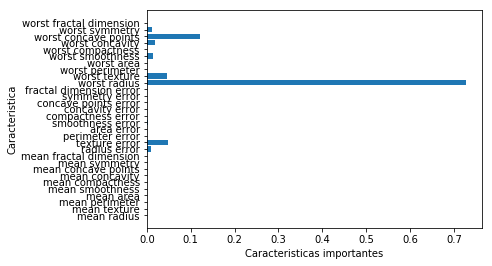

In [21]:
def dibuja_caracteristicas_importantes_cancer(modelo):
    n_caracteristica = cancer.data.shape[1]
    plt.barh(range(n_caracteristica), modelo.feature_importances_, align='center')
    plt.yticks(np.arange(n_caracteristica), cancer.feature_names)
    plt.xlabel("Caracteristicas importantes")
    plt.ylabel("Caracteristica")

dibuja_caracteristicas_importantes_cancer(arbol_decision)

Aquí vemos que la característica utilizada en la división superior (`worst_radio`) es con mucho la característica más importante. Esto confirma nuestra observación al analizar el árbol que el primer nivel ya separa bastante bien las dos clases.

Sin embargo, si una característica tiene una baja `feature_importance`, no significa que esta característica no sea informativa. Solo significa que la característica no fue seleccionada por el árbol, probablemente porque otra característica codifica la misma información.

A diferencia de los coeficientes en los modelos lineales, las importancias de las características siempre son positivas y no codifican a qué clase son una característica indicativa.

Las importantes características nos dicen que `worst_radio` es importante, pero no si un radio alto es indicativo de que una muestra es benigna o maligna. De hecho, es posible que no exista una relación tan simple entre las características y la clase, como se puede ver en el siguiente ejemplo:

In [22]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_separador_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1,
                      cm=cm2, ancholinea=None, umbral=None,
                      estilolinea="solid"):

    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        valor_decision = clasificador.decision_function(X_grid)
        niveles = [0] if umbral is None else [umbral]
        niveles_f = [valor_decision.min()] + niveles + [valor_decision.max()]
    except AttributeError:
        # No funciones de decision
        valor_decision = clasificador.predict_proba(X_grid)[:, 1]
        niveles = [.5] if umbral is None else [umbral]
        niveles_f = [0] + niveles + [1]
    if relleno:
        ax.contourf(X1, X2, valor_decision.reshape(X1.shape),
                    levels=niveles_f, alpha=alfa, cmap=cm)
    else:
        ax.contour(X1, X2, valor_decision.reshape(X1.shape), levels=niveles,
                   colors="black", alpha=alfa, linewidths=ancholinea,
                   linestyles=estilolinea, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [25]:
from sklearn.datasets import make_blobs
def dibuja_arbol_no_monotono():
    import graphviz
    # conjunto de datos 
    X, y = make_blobs(centers=4, random_state=8)
    y = y % 2
    plt.figure()
    dibuja_dispersion_discreta(X[:, 0], X[:, 1], y)
    plt.legend(["Clase 0", "Clase 1"], loc="best")

    # Modelo de arboles de decision
    arbol_decision1 = DecisionTreeClassifier(random_state=0).fit(X, y)
    dibuja_separador_2d(arbol_decision1, X, estilolinea="dashed")

    # visualizamos el arbol
    export_graphviz(arbol_decision1, out_file="arbol_decision1.dot", impurity=False, filled=True)
    with open("arbol_decision1.dot") as f:
        grafo_punto1 = f.read()
    print("Caracteristicas importantes: %s" % arbol_decision1.feature_importances_)
    return graphviz.Source(grafo_punto1)

Caracteristicas importantes: [0. 1.]


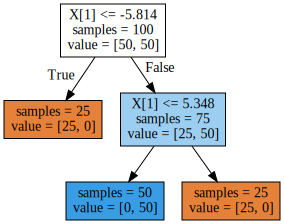

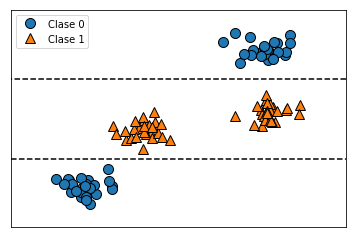

In [26]:
arbol_decision2 = dibuja_arbol_no_monotono()
display(arbol_decision2)

El diagrama muestra un conjunto de datos con dos características y dos clases. Aquí, toda la información está contenida en `X[1]` y `X[0]` no se usa en absoluto. Pero la relación entre `X[1]` y la clase de salida no es monótona, lo que significa que no podemos decir "un valor alto de `X[0]` significa clase 0, y un valor bajo significa clase 1 (o viceversa).


Todo lo que se dijo anteriormente es similarmente cierto para los árboles de decisión para regresión, tal como se implementa en DecisionTreeRegressor. El uso y análisis de los árboles de regresión es muy similar al de los árboles de clasificación.

Sin embargo, hay una propiedad particular de usar modelos basados en árboles para la regresión que queremos señalar. DecisionTreeRegressor (y todos los demás modelos de regresión basados en árboles) no pueden extrapolar ni hacer predicciones fuera del rango de los datos de entrenamiento.

Text(0,0.5,'Precios en $/Mbyte')

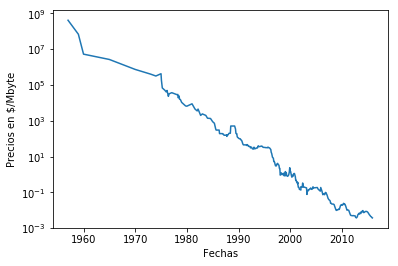

In [28]:
import pandas as pd
ram_precios = pd.read_csv("ram_precios.csv")
plt.semilogy(ram_precios.datos, ram_precios.precio)
plt.xlabel("Fechas")
plt.ylabel("Precios en $/Mbyte")

Vamos a hacer un pronóstico para los años posteriores a 2000 usando los datos históricos hasta ese momento, con la fecha como nuestra única característica. Después de entrenar los modelos y hacer predicciones, aplicamos el mapa exponencial para deshacer la transformación del logaritmo.

Reescalamos los precios usando un logaritmo, por lo que la relación es relativamente lineal.

Aquí hacemos predicciones sobre todo el conjunto de datos con fines de visualización, pero para una evaluación cuantitativa solo deberíamos considerar el conjunto de datos de prueba:

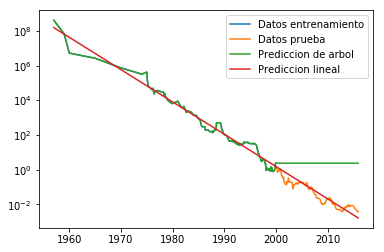

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Utilizamos datos historicos para pronosticar los precios despues del año 2000
datos_entrenamiento = ram_precios[ram_precios.datos < 2000]
datos_prueba = ram_precios[ram_precios.datos >= 2000]

# Predecimos precios basados en la fecha
X_entrenamiento = datos_entrenamiento.datos[:, np.newaxis]

# we use a log-transform to get a simpler relationship of data to target
y_entrenamiento = np.log(datos_entrenamiento.precio)
arbol_decision2 = DecisionTreeRegressor().fit(X_entrenamiento, y_entrenamiento)
reg_lineal = LinearRegression().fit(X_entrenamiento, y_entrenamiento)

# Predecimos en todos los datos
X_total = ram_precios.datos[:, np.newaxis]
arbol_prediccion = arbol_decision2.predict(X_total)
rl_prediccion_ = reg_lineal.predict(X_total)

# Deshacer la transformacion
arbol_precio = np.exp(arbol_prediccion)
rl_precio = np.exp(rl_prediccion_)

plt.semilogy(datos_entrenamiento.datos, datos_entrenamiento.precio, label="Datos entrenamiento")
plt.semilogy(datos_prueba.datos, datos_prueba.precio, label="Datos prueba")
plt.semilogy(ram_precios.datos, arbol_precio, label="Prediccion de arbol")
plt.semilogy(ram_precios.datos, rl_precio, label="Prediccion lineal")
plt.legend()

La diferencia entre los modelos es bastante sorprendente. El modelo lineal aproxima los datos con una línea, como sabíamos que sucedería. Esta línea proporciona un pronóstico bastante bueno para los datos de prueba (los años posteriores a 2000), mientras se pasan por alto algunas de las variaciones más finas tanto en el entrenamiento como en los datos de prueba.

El modelo de árbol, por otro lado, hace predicciones perfectas sobre los datos de entrenamiento; no restringimos la complejidad del árbol, por lo que aprendió todo el conjunto de datos de memoria.

Sin embargo, una vez que salimos del rango de datos para el cual el modelo tiene datos, el modelo simplemente sigue prediciendo el último punto conocido. El árbol no tiene la capacidad de generar respuestas "nuevas", aparte de lo que se vio en los datos de entrenamiento. Esta deficiencia se aplica a todos los modelos basados en árboles.

En realidad, es posible hacer pronósticos muy buenos con modelos basados en árbol (por ejemplo, cuando se trata de predecir si un precio subirá o bajará). El objetivo de este ejemplo no era mostrar que los árboles son un mal modelo para series de tiempo, sino ilustrar una propiedad particular de cómo los árboles hacen predicciones.


### Fortalezas, debilidades y paramétros

Los parámetros que controlan la complejidad del modelo en los árboles de decisión son los parámetros previos a la poda que detienen la construcción del árbol antes de que esté completamente desarrollado. Por lo general, elegir una de las estrategias previas a la poda (establecer `max_depth`, `max_leaf_nodes`, o `min_samples_leaf`) es suficiente para evitar el sobreajuste.

Los árboles de decisión tienen dos ventajas sobre muchos de los algoritmos que hemos discutido hasta ahora: el modelo resultante puede ser fácilmente visualizado y entendido por personas inexpertas (al menos para árboles pequeños), y los algoritmos son completamente invariables con  escalar los datos. 

Como cada característica se procesa por separado, y las posibles divisiones de los datos no dependen de la escala, no se requiere un preprocesamiento como la normalización o la estandarización de las características para los algoritmos del árbol de decisión. En particular, los árboles de decisión funcionan bien cuando tiene características que están en escalas completamente diferentes, o una combinación de características binarias y continuas.

La principal desventaja de los árboles de decisión es que incluso con el uso de una previa poda, tienden a sobreajustar y a proporcionar un rendimiento de generalización deficiente. Por lo tanto, en la mayoría de las aplicaciones, los métodos de emsamblado  se usan generalmente en lugar de un único árbol de decisión.